# <span style="color:blue"> Esercitazione 2 - Calcolo Monte Carlo di integrali e simulazione di random walk </span>

## <span style="color:blue"> Indice</span>

- [Esercizio 2.1 - Calcolo di un integrale con metodi Monte Carlo](#Esercizio2.1)

- [Esercizio 2.2 - Simulazione di random walk in tre dimensioni](#Esercizio2.2)

In [448]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## <span id="Esercizio2.1" style="color:blue">  Esercizio 2.1 - Calcolo di un integrale con metodi Monte Carlo </span>[^](#toc)

In questo esercizio è stato eseguito il calcolo Monte Carlo dell'integrale in $[0,1]$ della funzione $$f(x)=\frac{\pi}{2}\cos(\frac{\pi}{2}x)$$
Il valore dell'integrale è ottenibile analiticamente: $$I=\int_0^1 f(x)dx=1$$
Il calcolo è stato eseguito
1.  Campionando uniformemente l'intervallo di integrazione e valutando l'integranda nei punti generati
2.  Attraverso la tecnica dell'_importance sampling_, più elaborata ma più performante

### i. Calcolo attraverso campionamento uniforme di $[0,1]$

#### Descrizione

Uno dei modi più semplici e immediati per eseguire il calcolo di $I$ è un'applicazione diretta del teorema del valor medio:
$$\int_a^b f(x)dx=(b-a)<f>_{[a,b]}$$
dove $<f>_{[a,b]}$ è il valor medio dell'integranda $f$ sull'intervallo di integrazione $[a,b]$.

Campionando uniformemente l'intervallo $[a,b]$ un gran numero di volte, e valutando ogni volta $f$ nel punto generato, la media dei valori ottenuti approssima il valor medio "vero" (integrale) di $f$ in $[a,b]$. In questo caso, $a=0$ e $b=1$, perciò
$$I=<f>_{[0,1]}$$
Si può quindi calcolare $I$ nel seguente modo:
- si genera un gran numero $M$ di punti $\{x_j\}_{j=1}^M$ campionando la distribuzione $U([a,b))$, e si calcolano i valori $\{f(x_j)\}_{j=1}^M$
- si dividono i valori in $N$ blocchi lunghi $L=M/N$; in ogni blocco si calcola la stima dell'integrale,$I_i$ con $i=1,...,N$, come la media dei valori di $f$ ottenuti al suo interno
- il valor medio progressivo e l'incertezza progressiva del calcolo sono dati da $$<I>_n=\frac{1}{n}\sum_{i=1}^n{I_i}\quad \mathrm{e} \quad \sigma_{<I>_n}=\sqrt{\frac{<I^2>_n-<I>_n^2}{n-1}}$$
  dove $n=1,...,N$ è il numero di blocchi considerati nella media, partendo dal primo.
- valor medio e incertezza (finali) del calcolo sono dati da $<I>=<I>_N$ e $\sigma_{<I>}=\sigma_{<I>_N}$

Per maggiori dettagli sulla media a blocchi, si rimanda all'_Esercizio 1.1_ del notebook dell'_Esercitazione 1_ (paragrafo _Nota sulla media a blocchi_).

#### Calcolo e risultati

Il calcolo è stato svolto con $M=10^7$ campionamenti e $N=10^3$ blocchi, ovvero $10^3$ stime di $I$. Ogni blocco è lungo $L=M/N=10^4$.

Di seguito è mostrato l'andamento della media progressiva $<I>_n$ in funzione del numero di blocchi $n$, con barre di errore date dalle $\sigma_{<I>_n}$ ($\sigma_{<I>_1}=0$).

In [312]:
# Load the data (uniform sampling)
# Notation: "Ius"=value of I obtained with uniform sampling
Path="../Es02_01/Output/I_uniform_sampling.dat"
(
    IusBlockNumber,            # Block indexes (1-N)
    IusBlockAverage,           # Block estimates: IusBlockAverage[i]=estimate in block i+1 (i=0-N-1)
    IusMeanValueProg,          # Progressive averages <I>: IusMeanValueProg[i]=<I> estimated over the first (i+1) blocks
    IusStDevOfTheMeanProg      # Progressive statistical uncertainty of <I>: IusStDevOfTheMeanProg[i]=uncertainty of IusMeanValueProg[i]
)=np.loadtxt(Path,usecols=(0,1,2,3),unpack=True)

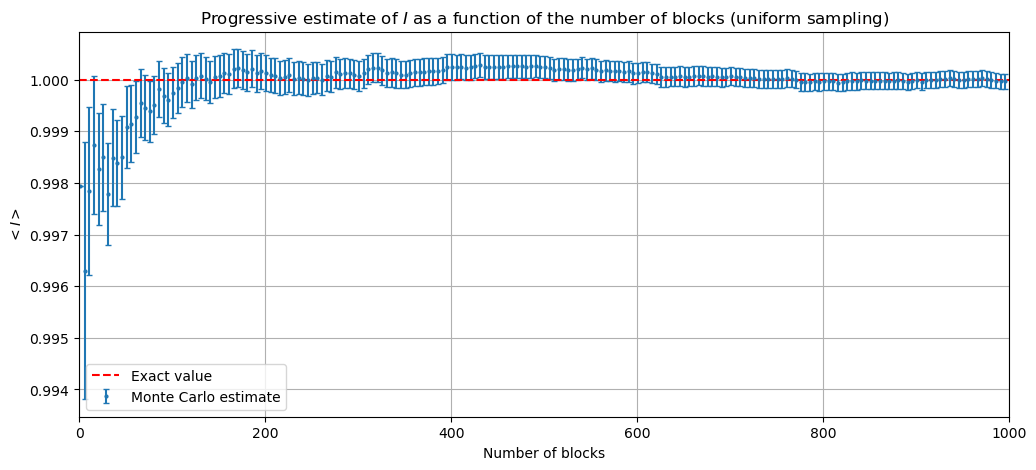

In [314]:
# Plot the progressive average
k=5  # plot one point every k blocks
plt.figure(figsize=(12,5))
plt.errorbar(IusBlockNumber[::k],IusMeanValueProg[::k],yerr=IusStDevOfTheMeanProg[::k],fmt='.',markersize=4,capsize=2,label='Monte Carlo estimate')
plt.axhline(1.0,color='r',linestyle='--',label='Exact value')
plt.title('Progressive estimate of $I$ as a function of the number of blocks (uniform sampling)')
plt.xlabel('Number of blocks')
plt.ylabel(r'$<I>$')
plt.xlim(0,IusBlockNumber[-1])
plt.ylim()
plt.legend()
plt.grid(True)
plt.show()

Dal grafico si osserva che
- la stima progressiva di $⟨I⟩$ converge verso il valore atteso $1$, con fluttuazioni sempre minori attorno ad esso, al crescere del numero di blocchi
- l'errore statistico sulla media
    - diminuisce al crescere del numero di blocchi
    - dopo un certo numero di blocchi segue un andamento regolare (raggiunge il regime asintotico). In questo regime la stima dell’errore statistico è affidabile.

Per maggiori dettagli sull'andamento dell'errore statistico quando si esegue la media a blocchi, e il suo legame con il teorema del limite centrale, si rimanda al paragrafo _Digressione sul teorema del limite centrale_ dell'_Esercizio 1.1_ del notebook dell'_Esercitazione 1_.

Il risultato del calcolo è:

In [316]:
print(f"<I>={IusMeanValueProg[-1]:.5f}±{IusStDevOfTheMeanProg[-1]:.5f}")

<I>=0.99997±0.00015


che risulta compatibile statisticamente con il valore atteso ampiamente entro $1\sigma$:

In [318]:
z=np.abs(IusMeanValueProg[-1]-1)/IusStDevOfTheMeanProg[-1]
print(f"z={np.round(z,2)}")

z=0.17


### ii. Calcolo attraverso importance sampling

#### Descrizione

L’_importance sampling_ è una tecnica Monte Carlo in cui i punti non vengono campionati uniformemente, ma secondo una distribuzione di probabilità opportunamente scelta in modo da essere simile alla funzione integranda. Si può dimostrare che una simile scelta permette di ridurre la varianza della stima dell'integrale, migliorando l'accuratezza del calcolo a parità di iterazioni o permettendo di raggiungere una data accuratezza con un numero minore di iterazioni.

L'idea di base è la seguente:
- si riscrive la funzione integranda come $f(x)=g(x)\rho(x)$, dove $\rho(x)$ è una densità di probabilità sull'intervallo di integrazione $[a,b]$. In questo modo, l'integrale risulta essere il valor medio della funzione ausiliaria $g$ rispetto alla distribuzione $\rho$:
$$\int_a^b f(x)dx=\int_a^b g(x)\rho(x)dx=<g>_{\rho,[a,b]} $$
- campionando quindi l'intervallo $[a,b]$ secondo la distribuzione $\rho(x)$ un gran numero di volte, e valutando ogni volta $g$ nel punto generato, la media dei valori ottenuti approssima il valore "vero" dell'integrale $I$.
- si dimostra che più $\rho$ è simile (in senso di forma/variazioni, non di valore assoluto) a $f$, minore è l'incertezza del calcolo a parità di iterazioni

Si può quindi calcolare $I$ nel seguente modo:
- si sceglie una distribuzione $\rho(x)$ simile a $f(x)$ in $[0,1]$ e si implementa un metodo per campionarla
- si genera un gran numero $M$ di punti $\{x_j\}_{j=1}^M$ campionando $\rho(x)$, e si calcolano i valori $\left\{\, g(x_j)=\frac{f(x_j)}{\rho(x_j)} \,\right\}_{j=1}^M$. Risulta evidente che sia importante scegliere una $\rho(x)$ che non si annulli laddove $f(x)$ non si annulla.
- si dividono i valori in $N$ blocchi lunghi $L=M/N$; in ogni blocco si calcola la stima dell'integrale,$I_i$ con $i=1,...,N$, come la media dei valori di $g$ ottenuti al suo interno
- il valor medio progressivo $<I>_n$ e l'incertezza progressiva $\sigma_{<I>_n}$ del calcolo sono dati dalle stesse formule mostrate nel paragrafo precedente
- valor medio e incertezza (finali) del calcolo sono dati da $<I>=<I>_N$ e $\sigma_{<I>}=\sigma_{<I>_N}$

#### Calcolo e risultati

Il calcolo è stato svolto con $M=10^7$ campionamenti e $N=10^3$ blocchi, ovvero $10^3$ stime di $I$. Ogni blocco è lungo $L=M/N=10^4$.

La distribuzione $\rho(x)$ scelta è stata ricavata dallo sviluppo di Taylor al primo ordine di $f(x)$ centrato in $x=1/2$, punto medio di $[0,1]$:
- $f(x)\simeq f(\frac{1}{2})+f'(\frac{1}{2}) \left(x-\frac{1}{2}\right)=\frac{\sqrt2\pi}{4}-\frac{\sqrt2\pi^2}{8}\left(x-\frac{1}{2}\right)$
- normalizzando si ottiene $\rho(x)=\left(1+\frac{\pi}{4}\right)-\frac{\pi}{2}x$
- si osserva che questa funzione non si annulla in $[0,1]$

Per generare numeri pseudo-casuali distribuiti secondo $\rho(x)$ è stato implementato il metodo dell'inversione della cumulativa:
- cumulativa di $\rho(x)$: $F(x)=\left(1+\frac{\pi}{4}\right)x-\frac{\pi}{4}x^2$
- inversa in $[0,1]$: $F^{-1}(x)=\left(\frac{2}{\pi}+\frac{1}{2}\right)-\sqrt{\left(\frac{2}{\pi}+\frac{1}{2}\right)^2-\frac{4}{\pi}x}$
- si generano quindi numeri $\{x_j\}_{j=1}^M$ uniformemente distribuiti in $[0,1]$, e si ottiene la sequenza dei numeri $\{F^{-1}(x_j)\}_{j=1}^M$, distribuiti secondo $\rho$

Di seguito è mostrato l'andamento della media progressiva $<I>_n$ in funzione del numero di blocchi $n$, con barre di errore date dalle $\sigma_{<I>_n}$ ($\sigma_{<I>_1}=0$).

In [320]:
# Load the data (importance sampling)
# Notation: "Iis"=value of I obtained with importance sampling
Path="../Es02_01/Output/I_importance_sampling.dat"
(
    IisBlockNumber,            # Block indexes (1-N)
    IisBlockAverage,           # Block estimates: IisBlockAverage[i]=estimate in block i+1 (i=0-N-1)
    IisMeanValueProg,          # Progressive averages <I>: IisMeanValueProg[i]=<I> estimated over the first (i+1) blocks
    IisStDevOfTheMeanProg      # Progressive statistical uncertainty of <I>: IisStDevOfTheMeanProg[i]=uncertainty of IisMeanValueProg[i]
)=np.loadtxt(Path,usecols=(0,1,2,3),unpack=True)

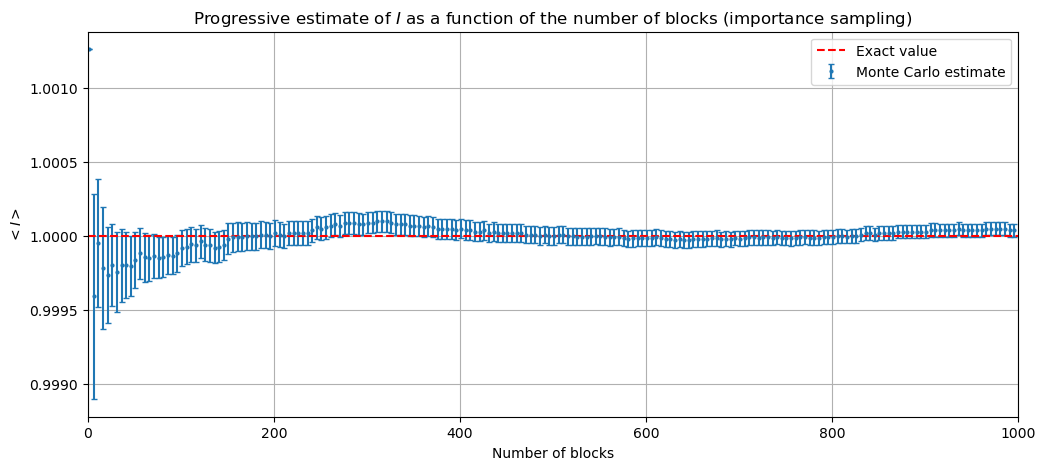

In [322]:
# Plot the progressive average
k=5  # plot one point every k blocks
plt.figure(figsize=(12,5))
plt.errorbar(IisBlockNumber[::k],IisMeanValueProg[::k],yerr=IisStDevOfTheMeanProg[::k],fmt='.',markersize=4,capsize=2,label='Monte Carlo estimate')
plt.axhline(1.0,color='r',linestyle='--',label='Exact value')
plt.title('Progressive estimate of $I$ as a function of the number of blocks (importance sampling)')
plt.xlabel('Number of blocks')
plt.ylabel(r'$<I>$')
plt.xlim(0,IisBlockNumber[-1])
plt.ylim()
plt.legend()
plt.grid(True)
plt.show()

Anche in questo caso:
- la stima progressiva di $⟨I⟩$ converge verso il valore atteso $1$, con fluttuazioni sempre minori attorno ad esso, al crescere del numero di blocchi
- l'errore statistico sulla media
    - diminuisce al crescere del numero di blocchi
    - dopo un certo numero di blocchi segue un andamento regolare.

Il risultato del calcolo è:

In [324]:
print(f"<I>={IisMeanValueProg[-1]:.6f}±{IisStDevOfTheMeanProg[-1]:.6f}")

<I>=1.000040±0.000043


che risulta compatibile statisticamente con il valore atteso entro $1\sigma$:

In [326]:
z=np.abs(IisMeanValueProg[-1]-1)/IisStDevOfTheMeanProg[-1]
print(f"z={np.round(z,2)}")

z=0.93


### iii. Confronto

Il risultato del calcolo Monte Carlo è in accordo con quello esatto in entrambi i casi:

In [335]:
print(f"Uniform sampling:    <I>= {IusMeanValueProg[-1]:.6f} ± {IusStDevOfTheMeanProg[-1]:.6f}")
print(f"Importance sampling: <I>= {IisMeanValueProg[-1]:.6f} ± {IisStDevOfTheMeanProg[-1]:.6f}")

Uniform sampling:    <I>= 0.999975 ± 0.000150
Importance sampling: <I>= 1.000040 ± 0.000043


Di seguito sono confrontati gli andamenti del valor medio progressivo del calcolo, con relative incertezze, per le due metodologie di campionamento.

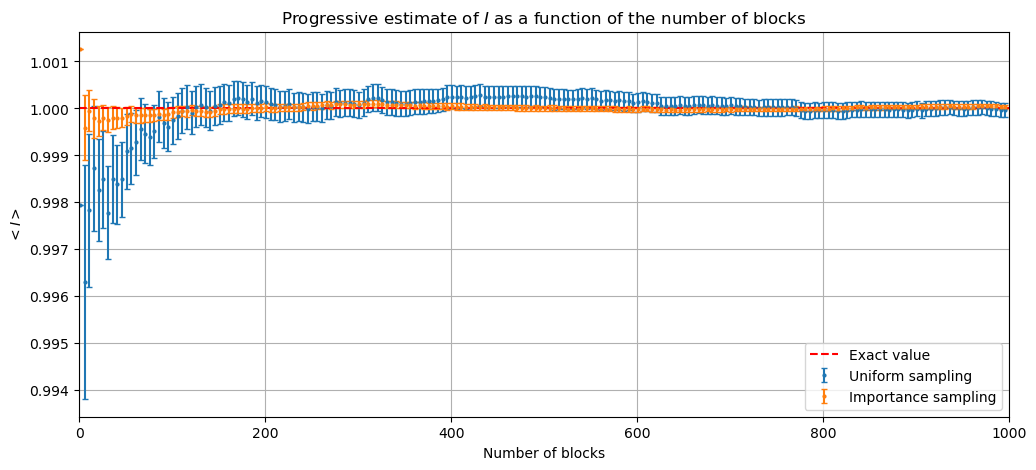

In [330]:
# Plot the progressive estimates: uniform vs importance sampling
k=5  # plot one point every k blocks
plt.figure(figsize=(12,5))
plt.errorbar(IusBlockNumber[::k],IusMeanValueProg[::k],yerr=IusStDevOfTheMeanProg[::k],fmt='.',markersize=4,capsize=2,label='Uniform sampling')
plt.errorbar(IisBlockNumber[::k],IisMeanValueProg[::k],yerr=IisStDevOfTheMeanProg[::k],fmt='.',markersize=4,capsize=2,label='Importance sampling')
plt.axhline(1.0,color='r',linestyle='--',label='Exact value')
plt.title('Progressive estimate of $I$ as a function of the number of blocks')
plt.xlabel('Number of blocks')
plt.ylabel(r'$<I>$')
plt.xlim(0,IusBlockNumber[-1])
plt.legend()
plt.grid(True)
plt.show()

Dal confronto tra i due andamenti si osserva che l’importance sampling fornisce
- una stima dell'integrale che converge più rapidamente al valore esatto: il valor medio è più vicino al valore esatto a parità del numero di blocchi, e ha un andamento più stabile 
- una maggior precisione: a parità del numero di blocchi, l'incertezza statistica sulla media è significativamente inferiore rispetto al campionamento uniforme (di un fattore dell'ordine 2-5)

L'importance sampling, implementato in questo esempio in modo piuttosto semplice (l'integranda è stata approssimata con una retta), risulta quindi più efficiente del campionamento uniforme per il calcolo di $I$.

Si osservi che il valore più elevato dello z-score ottenuto nel caso dell’importance sampling rispetto al campionamento uniforme è dovuto prevalentemente alla minore incertezza statistica sulla stima finale dell’integrale: a parità di scostamento assoluto dal valore atteso, una stima più precisa comporta uno z-score maggiore.

## <span id="Esercizio2.2" style="color:blue">  Esercizio 2.2 - Simulazione di random walk in tre dimensioni </span>[^](#toc)

In questo esercizio sono stati simulati due diversi tipi di random walk tridimensionali:
1. Random walk lungo le direzioni principali di un reticolo cubico di passo $a=1$
2. Random walk lungo direzioni qualsiasi nello spazio, con passi lunghi $a=1$

Dopo aver simulato un gran numero di random walks, si sono studiate le proprietà statistiche della distanza del walker dal punto di partenza.

### i. Random walk su un reticolo cubico

#### Descrizione

Il random walk implementato ha le seguenti caratteristiche:
- il punto di partenza è l'origine $(0,0,0)$
- il passo (_step_) avviene a tempi discreti
- la direzione del passo è sempre lungo uno dei tre assi cartesiani ($x$, $y$, $z$), posti lungo le tre direzioni principali del reticolo
- l'ampiezza del passo è sempre $a=1$, in accordo con la geometria del reticolo cubico.

Ad ogni step, quindi, ci sono $6$ possibili passi che possono avvenire: uno spostamento di $a$ in uno dei due sensi possibili lungo una delle tre direzioni. La simulazione della stocasticità del cammino è stata eseguita con un generatore che implementa il lancio di un dato non truccato a $6$ facce, e ad ogni faccia è stato associato un passo specifico:
- si genera un numero casuale $p$ campionando la distribuzione $U([0,6))$
- si ottiene un numero casuale $p'$ estratto dalla distribuzione discreta $U(\{1,2,3,4,5,6\})$ con $p'=\mathrm{floor}(p)+1$
- se $p'=1$, la coordinata $x$ del walker è incrementata di $+a$; se $p'=2$, $x$ è incrementata di $-a$; e così via.

Dato $N_{steps}$ il numero di passi totali del walker, è possibile calcolare la distanza media percorsa (distanza dall'origine) dopo un dato numero di passi $k=0,...,N_{steps}$.

Per fare ciò, è stato seguito questo procedimento:
- si considerano un numero $M$, molto grande, di cammini da generare, e un numero di blocchi $N$ opportuno in cui raggruppare i cammini. Ogni blocco contiene $L=M/N$ cammini.
- Dato un blocco (sia esso il blocco $i$-esimo):
    - dato un random walk del blocco (sia esso il $j$-esimo):
        - il walker parte da $(x,y,z)=(0,0,0)$
        - per ogni passo $k$, generato nel modo spiegato sopra, si calcola la distanza al quadrato $|\vec{r_k}|^2_{j}$
    - una volta fatto questo per tutti i random walk del blocco ($j=1,...,L$), si mediano i valori a passo $k$ fissato e si calcola la radice quadrata delle medie. Si ottengono
      $$\left(\sqrt{<|\vec{r}_0|^2>}\right)_i, \quad \left(\sqrt{<|\vec{r}_1|^2>}\right)_i \quad ... \quad \left(\sqrt{<|\vec{r}_{N_{steps}}|^2>}\right)_i$$
      stime delle distanze percorse dopo $0$, $1$,..., $N_{steps}$ passi, per l'$i$-esimo blocco, calcolate come rms delle medesime distanze per i singoli random walk. Questi sono i valori rappresentativi dell'$i$-esimo blocco. Si noti che la distanza rms per $k=0$ passi è zero.
- Dopo aver ripetuto il calcolo per tutti i blocchi, si ottengono i risultati della simulazione: chiamando, per semplicità, $\left(\sqrt{<|\vec{r}_k|^2>}\right)_i \equiv d_{k,i}$, si ha che
    - il valor medio della distanza percorsa dopo $k$ passi è
$$<\left(\sqrt{<|\vec{r}_k|^2>}\right)> \equiv d_k=\frac{1}{N}\sum_{i=1}^N{d_{k,i}}$$
    - l'incertezza statistica del valor medio dopo $k$ passi è
$$\sigma_{<\left(\sqrt{<|\vec{r}_k|^2>}\right)>} \equiv \sigma_{d_k}=\sqrt{\frac{\frac{1}{N}\sum_{i=1}^N{d_{k,i}^2}-(\frac{1}{N}\sum_{i=1}^N{d_{k,i}})^2}{N-1}}$$

#### Calcolo e risultati

Parametri del calcolo:
- $M=10^6$ random walk generati
- $N=10^3$ blocchi, ciascuno contenente $L=M/N=10^3$ cammini
- $N_{steps}=100$ step per ciascun cammino

Di seguito si mostra l'andamento del risultato del calcolo (distanza rms media dall'origine, $d_k$) in funzione del numero di passi eseguiti ($k$ da $0$ a $100$), con barre di errore date dalle $\sigma_{d_k}$. Viene eseguito un fit con una funzione $f(k)=A\sqrt{k}$, per verificare il comportamento di tipo diffusivo del moto stocastico appena simulato.

In [575]:
# Load the data (random walk on a cubic lattice)
# Notation: "_l"=quantities related to the random walk on the lattice
Path = "../Es02_02/Output/results_lattice.dat"
(
    Step_l,                         # Step index k (0-N_steps)
    rmsdistanceMeanValue_l,         # Root mean square distance sqrt(<|r_k|^2>) after k steps - Value averaged over blocks
    rmsdistanceStDevOfTheMean_l     # Statistical uncertainty on sqrt(<|r_k|^2>): rmsdistanceStDevOfTheMean_l[k]=uncertainty of rmsdistanceMeanValue_l[k]
)=np.loadtxt(Path,usecols=(0,1,2),unpack=True)

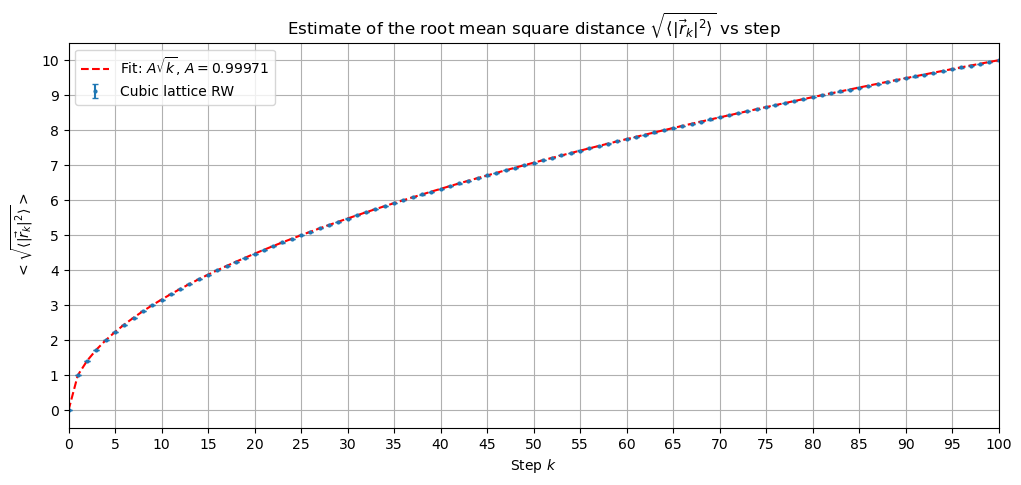

In [601]:
# Fit to a diffusive law: f(k)=A*sqrt(k)
def diffusive_law(k, A):
    return A*np.sqrt(k)
popt_l,pcov_l=curve_fit(diffusive_law,Step_l[1:],rmsdistanceMeanValue_l[1:])
A_l=popt_l[0]
Aerr_l=np.sqrt(pcov_l[0,0])

# Plot the root mean square distance as a function of the step (random walk on a cubic lattice)
plt.figure(figsize=(12,5))
plt.errorbar(Step_l,rmsdistanceMeanValue_l,yerr=rmsdistanceStDevOfTheMean_l,fmt='.',markersize=4,capsize=2,label='Cubic lattice RW')
plt.plot(Step_l,diffusive_law(Step_l,A_l),'r--',label=rf'Fit: $A\sqrt{{k}}$, $A={A_l:.5f}$')
plt.title(r'Estimate of the root mean square distance $\sqrt{\langle |\vec{r}_k|^2 \rangle}$ vs step')
plt.xlabel('Step $k$')
plt.ylabel(r'$<\sqrt{\langle |\vec{r}_k|^2 \rangle}>$')
plt.xlim(0,Step_l[-1])
plt.xticks(np.arange(0,Step_l[-1]+1,5))
plt.yticks(np.arange(0,11,1))
plt.legend()
plt.grid(True)
plt.show()

- I risultati ottenuti mostrano un ottimo accordo con la legge del tipo $f(k)=A\sqrt{k}$. Il parametro di fit $A$ risulta compatibile con l'unità, come atteso per un random walk tridimensionale su reticolo cubico con $a=1$. Questo conferma il comportamento diffusivo del moto stocastico simulato.
- Le incertezze statistiche associate alle stime della distanza rms risultano molto piccole, al punto da rendere le barre di errore quasi invisibili nel grafico; ciò è dovuto all’elevata statistica utilizzata nella simulazione.

Per verificare quantitativamente la bontà del fit con la legge diffusiva $f(k)=A\sqrt{k}$ è stato eseguito un test del $\chi^2$. Esso consente di valutare se le deviazioni tra i dati simulati e il modello teorico siano compatibili con le incertezze statistiche associate ai dati.

Per farlo, si calcola
$$\chi^2=\sum_{k=1}^{N_{points}}{\frac{(d_k-f(k))^2}{\sigma_{d_k}^2}}$$
e poi si ottiene il $\chi^2$ ridotto: $\chi^2_{\nu}=\chi^2/\nu$, dove $\nu=N_{points}-1$ è il numero di gradi di libertà. In questo caso, nel calcolo sono stati esclusi i punti per cui l’incertezza statistica risulta nulla, perciò $N_{points}<N_{steps}$.

In [675]:
mask=rmsdistanceStDevOfTheMean_l[1:]>0
Chi2=np.sum(((rmsdistanceMeanValue_l[1:][mask]-diffusive_law(Step_l[1:][mask],A_l))/rmsdistanceStDevOfTheMean_l[1:][mask])**2)
DoF=np.sum(mask)-1
Chi2Red=Chi2/DoF
print(f"Chi2_red={Chi2Red:.2}")

Chi2_red=0.45


Questo risultato ($\chi^2_{\nu}\simeq 0.45$) indica che i dati sono compatibili con il modello diffusivo entro le incertezze statistiche.

### ii. Random walk nel continuo

#### Descrizione

Il random walk implementato ha le seguenti caratteristiche:
- il punto di partenza è l'origine $(0,0,0)$
- il passo (_step_) avviene a tempi discreti
- la direzione del passo è una qualsiasi direzione nello spazio, distribuita uniformemente nell'angolo solido
- l'ampiezza del passo è sempre $a=1$.

Ad ogni step, quindi, è necessario generare la coppia di angoli $(\phi,\theta)$ che individuano la direzione nello spazio. Poiché l’elemento di angolo solido è $d\Omega \propto \sin{\theta} d\theta d\phi$:
- $\phi$, con valori possibili in $[0,2\pi)$, è estratto da $U([0,2\pi))$
- $\theta$, con valori possibili in $[0,\pi)$, è estratto da una distribuzione proporzionale a $\sin(\theta)$:
    - $\rho(\theta)=\frac{1}{2}\sin{\theta}$
    - si applica il metodo di inversione della cumulativa, con $\theta=F^{-1}(p)=\arccos(1-2p)$ e $p$ estratto da $U([0,1))$

Dopo aver generato $(\phi,\theta)$, le coordinate del walker sono aggiornate: $x$ è incrementata di $a\sin{\theta}\cos{\phi}$, $y$ è incrementata di $a\sin{\theta}\sin{\phi}$ e $z$ è incrementata di $a\cos{\theta}$.

Il resto dei passaggi è identico a quanto spiegato nel caso precedente.

#### Calcolo e risultati

Parametri del calcolo:
- $M=10^6$ random walk generati
- $N=10^3$ blocchi, ciascuno contenente $L=M/N=10^3$ cammini
- $N_{steps}=100$ step per ciascun cammino

Di seguito si mostra l'andamento del risultato $d_k$ in funzione del numero di passi eseguiti $k$, con barre di errore date dalle $\sigma_{d_k}$. Viene eseguito un fit con $f(k)=A\sqrt{k}$.

In [664]:
# Load the data (random walk in the continuum)
# Notation: "_c"=quantities related to the random walk in the continuum
Path = "../Es02_02/Output/results_continuum.dat"
(
    Step_c,                         # Step index k (0-N_steps)
    rmsdistanceMeanValue_c,         # Root mean square distance sqrt(<|r_k|^2>) after k steps - Value averaged over blocks
    rmsdistanceStDevOfTheMean_c     # Statistical uncertainty on sqrt(<|r_k|^2>): rmsdistanceStDevOfTheMean_c[k]=uncertainty of rmsdistanceMeanValue_c[k]
)=np.loadtxt(Path,usecols=(0,1,2),unpack=True)

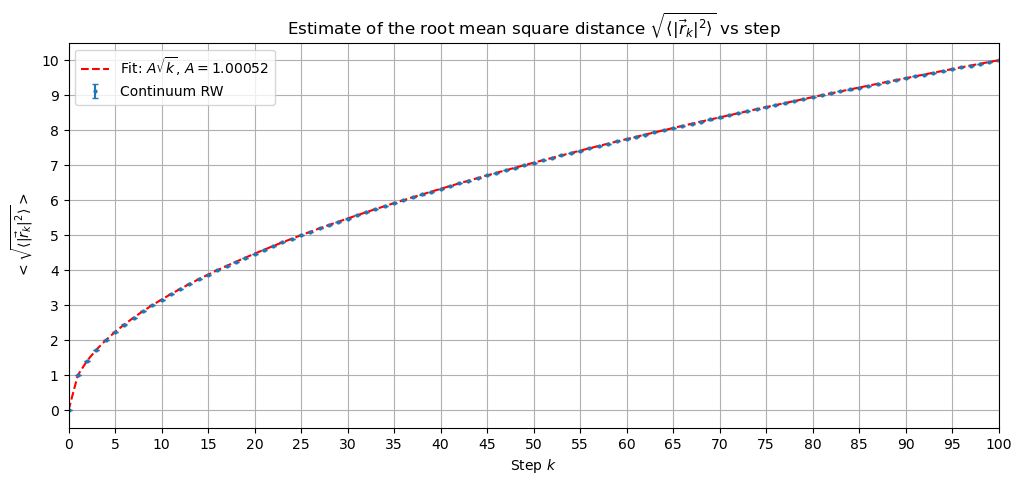

In [671]:
# Fit to a diffusive law: f(k)=A*sqrt(k)
popt_c,pcov_c=curve_fit(diffusive_law,Step_c[1:],rmsdistanceMeanValue_c[1:])
A_c=popt_c[0]
Aerr_c=np.sqrt(pcov_c[0,0])

# Plot the root mean square distance as a function of the step (random walk in the continuum)
plt.figure(figsize=(12,5))
plt.errorbar(Step_c,rmsdistanceMeanValue_c,yerr=rmsdistanceStDevOfTheMean_c,fmt='.',markersize=4,capsize=2,label='Continuum RW')
plt.plot(Step_c,diffusive_law(Step_c,A_c),'r--',label=rf'Fit: $A\sqrt{{k}}$, $A={A_c:.5f}$')
plt.title(r'Estimate of the root mean square distance $\sqrt{\langle |\vec{r}_k|^2 \rangle}$ vs step')
plt.xlabel('Step $k$')
plt.ylabel(r'$<\sqrt{\langle |\vec{r}_k|^2 \rangle}>$')
plt.xlim(0,Step_c[-1])
plt.xticks(np.arange(0,Step_c[-1]+1,5))
plt.yticks(np.arange(0,11,1))
plt.legend()
plt.grid(True)
plt.show()

Come per il caso precedente:
- I risultati ottenuti mostrano un ottimo accordo con la legge del tipo $f(k)=A\sqrt{k}$. Il parametro di fit $A$ risulta compatibile con l'unità, come atteso, a conferma del comportamento diffusivo del moto simulato.
- Le incertezze statistiche associate alle stime della distanza rms risultano molto piccole.

Di seguito si riporta il risultato del test del $\chi^2$.

In [677]:
mask=rmsdistanceStDevOfTheMean_c[1:]>0
Chi2=np.sum(((rmsdistanceMeanValue_c[1:][mask]-diffusive_law(Step_c[1:][mask],A_c))/rmsdistanceStDevOfTheMean_c[1:][mask])**2)
DoF=np.sum(mask)-1
Chi2Red=Chi2/DoF
print(f"Chi2_red={Chi2Red:.2}")

Chi2_red=0.65


Anche per il random walk nel continuo, i dati sono compatibili statisticamente con il modello diffusivo ($\chi^2_{\nu}\simeq 0.65$).